# Magnetometer Calibration using a Least Squares Fit in Python

Magnetometers can be difficult to calibrate, and working with them can be frustrating if you don't understand the underlying principles affecting the calibration.  This python tutorial demonstrates how magnetometers are calibrated and why some calibration methods don't work well, including hard and soft iron corrections.  There is calibration software that can be found online, but tutorial this is written so the calibration is being done in the most transparent way possible in order to demonstrate what's happening rather than it being a black box.  To do this, I create functions that use least squares fitting for calibration.

The final goal is to calibrate 3-axis data that has both hard and soft iron effects.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import HTML, Image


## 2-Axis Calibration: Gain and Hard Iron Offsets

Before looking at 3-axis data, it's best to understand 2-axis data first.  This would be made by a magnetometer that has its z-axis pointed vertically up or down, with the x- and y-axis staying horizontal.

The magnetometer can be calibrated by having the x- and y-axis readings range from -1 to 1.  When this is done, the data will all be on a unit circle.  This can be done by scaling the data, by dividing by the magnitudes.  The magnitude of the x-axis data can be different from the y-axis data due to having different gains, which results in the data points making an elliptical shape rather than a circle.  Here we can make data that illustrates this.

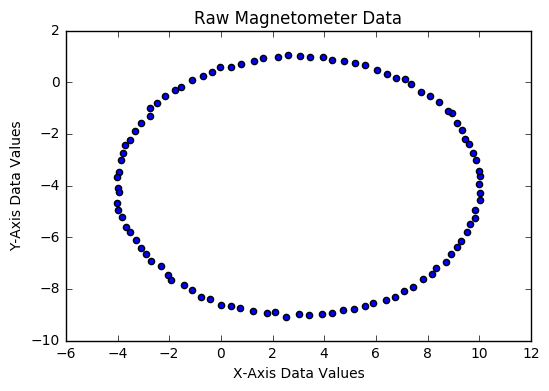

In [2]:
    #data parameters
npts = 100
rad = np.arange(npts)*2*np.pi/(npts)
xc = 3
yc = -4
xm = 7
ym = 5
x_noise = np.random.normal(0,0.05,npts)
y_noise = np.random.normal(0,0.05,npts)

    #make data
x = np.cos(rad)*xm+xc+x_noise
y = np.sin(rad)*ym+yc+y_noise

    #plot
plt.axis('equal')
plt.title('Raw Magnetometer Data')
plt.ylabel('Y-Axis Data Values')
plt.xlabel('X-Axis Data Values')
plt.scatter(x,y)
plt.show()



However, if there are any sources of permanent magnetic fields, for example in the electronics the magnetometer is connected to, it will add a constant to the x- and y-axis data.  This will show up as the data being offset, called a hard iron offset, so the center of the ellipse is not at the origin.

Looking at data, let's have the center of the ellipse be determined by xc and yc, and the magnitudes of the semi-major and semi-minor axes be xm and ym.  Using this notation, the equation for an ellipse would be found by

$$
\frac{(x-x_c)^2}{x_m^2}+\frac{(y-y_c)^2}{y_m^2}=1
$$

This gif shows the data before and after calibration, showing how it is mapped onto the unit circle.

![2D Hard Iron](https://fat.gfycat.com/AridTepidImperialeagle.gif)

As can be seen, the raw data is in the shape of an ellipse.  To calibrate the magnetomter, we can find the ellipse parameters (magnitudes of semi-major and semi-minor axes, and location of center).  We can then use these parameters to fit the data onto a unit circle centered at the origin.  This will be done by the following:

1. Use least squares fitting to find an elliptical fit to the data.
2. Center the data at the origin by subtracting off the center of the ellipse fit.
3. Normalize the data by dividing by the magnitude of the axes of the ellipse fit.

The goal will be to calcuate xc, yc, xm, and ym by fitting the data ellipse.  Here we create the function (calc_params2) of an ellipse that can be used to fit the data, and the least squares function (lq_function2) will return the best fit parameters.

In [3]:
def calc_params2(x_c, y_c, x_m, y_m):
    return (((x-x_c)/x_m)**2 + ((y-y_c)/y_m)**2)    
    
def lq_function2(c):
    fit = calc_params2(*c)
    return fit - 1

In order to get estimates for the parameters, we can use the relationships that the center should be the average of the minimum and maximum values, or:

$$
x_c = \frac{x_{max}+x_{min}}{2}
$$

and the magnitude should be the half the difference between the minimum and maximum values, or:

$$
x_m = \frac{x_{max}-x_{min}}{2}
$$


In [4]:
    #ellipse center
xc_est = (x.max()+x.min())/2.
yc_est = (y.max()+y.min())/2.

    #semi-major and semi-minor axis magnitudes
xm_est = (x.max()-x.min())/2.
ym_est = (y.max()-y.min())/2.

Here we fit the data.  The returned variable params_2 contains the fit parameters, and ier notes if the fit was successful (must be <5).  The general form for an ellipse is equal to 1, and we can see how well the fit was by finding the sum of the squares of the residuals.

Make an ellipse with the fit parameters with a full circle array to view the fit.

Real parameters
[x center, y center, x magnitude, y magnitude]
[ 3 -4  7  5]

Fit parameters
[ 3.    -4.006  7.01   5.014]


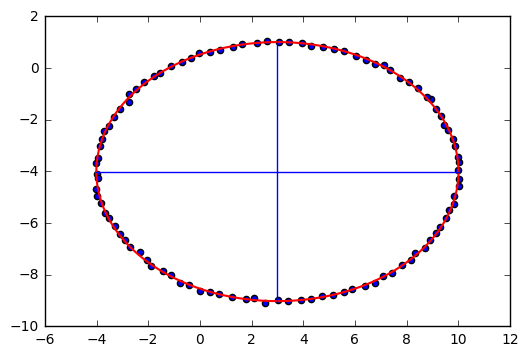

In [5]:
    #fit the data
params_estimate = xc_est, yc_est, xm_est, ym_est
params_2, ier = optimize.leastsq(lq_function2, params_estimate)
xc_fit, yc_fit, xm_fit, ym_fit = params_2

    #print fit parameters
np.set_printoptions(precision=3) #for pretty printing numpy
print 'Real parameters'
print '[x center, y center, x magnitude, y magnitude]'
print np.array([xc, yc, xm, ym])
print '\nFit parameters'
print np.array(params_2)

    #create fit array
npts_fit = 1000
rad_fit = np.arange(npts_fit)*2*np.pi/(npts_fit)
xfit = np.cos(rad_fit)*xm_fit+xc_fit
yfit = np.sin(rad_fit)*ym_fit+yc_fit

    #plot
plt.axis('equal')
plt.scatter(x, y) #data
plt.plot(xfit,yfit,color='r',linewidth=1.5) #fit to data
plt.plot([xc_fit-xm_fit,xc_fit+xm_fit],[yc_fit,yc_fit],color='b') #ellipse axes
plt.plot([xc_fit,xc_fit],[yc_fit-ym_fit,yc_fit+ym_fit],color='b')
plt.show()


The parameters can be used to calibrate the magnetometer and make a unit circle.

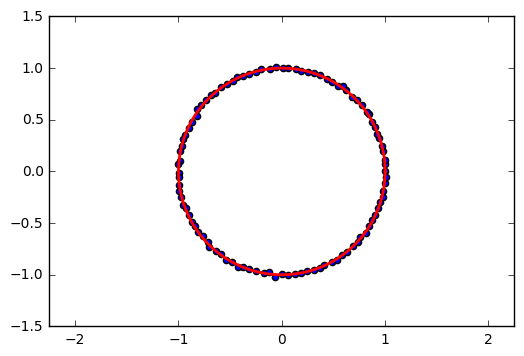

In [6]:
    #calibrate the data
x_cal = (x-xc_fit)/xm_fit
y_cal = (y-yc_fit)/ym_fit

    #make unit circle
xunit = np.cos(rad_fit)
yunit = np.sin(rad_fit)

    #plot
plt.axis('equal')
plt.scatter(x_cal, y_cal) #normalized data
plt.plot(xunit,yunit,color='r',linewidth=2) #unit circle
plt.show()

## 2D Calibration: Soft Iron, Scaling with a Symmetric Matrix

The soft iron effect introduces an off-axis skew to the data that can't be corrected by using just an offset and scaling, as illustrated here:

![2D Hard Iron](https://fat.gfycat.com/FinishedBreakableDorking.gif)

Once the data is centered at the origin, it will be symmetric along the semi-minor and semi-major axes of the ellipse.  The ellipse than then be fit with a symmetric matrix.  A symmetric matrix $A$ is equal to it's transpose ($A = A^T$).  Referring to the following matrix,

$$
A = \left( \begin{array}{ccc}
a_{xx} & a_{xy} & a_{xz} \\
a_{yx} & a_{yy} & a_{yz} \\
a_{zx} & a_{zy} & a_{zz} \end{array} \right)\\
$$

The matrix $A$ is symmetric if $a_{xy}=a_{yx}$, $a_{xz}=a_{zx}$, and $a_{yz}=a_{zy}$.

The symmetric matrix will scale the ellipse like before, but allowing for the ellipse axes not to be aligned with the x- and y-axes.  This can be seen here:

![2D Soft Iron](https://fat.gfycat.com/ObeseCorruptAmericancurl.gif)

Note that the data is not rotated when using a symmetric matrix.  Looking at the blue grid created to show how the data is skewed, it can be seen the horizontal lines rotate by the same angle as the vertical lines. 

Next, let's create some 2D data that displays off-axis skew as would be created by soft iron effects.


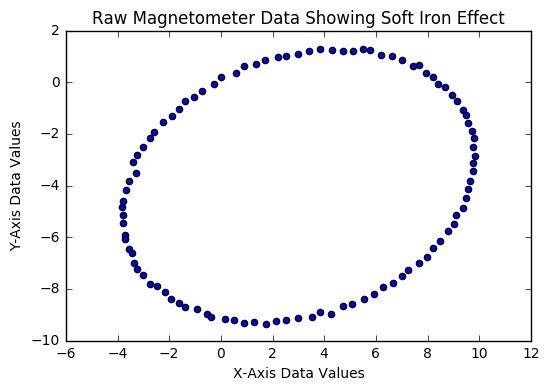

In [7]:
#create data showing soft iron effect
skew_deg = 20
skew_angle = np.radians(skew_deg)
x = xm*np.cos(rad)*np.cos(skew_angle)-ym*np.sin(rad)*np.sin(skew_angle)+xc+x_noise
y = xm*np.cos(rad)*np.sin(skew_angle)+ym*np.sin(rad)*np.cos(skew_angle)+yc+y_noise

#plot
plt.title('Raw Magnetometer Data Showing Soft Iron Effect')
plt.ylabel('Y-Axis Data Values')
plt.xlabel('X-Axis Data Values')
plt.axis('equal')
plt.scatter(x,y)
plt.show()


Next we create the functions that will be used to fit the data, estimate the parameters, and then fit the data.

Hard Iron Offsets
[ 3.002 -4.005]

Scaling and Skew Correction Matrix
[[ 6.781  0.644]
 [ 0.644  5.241]]


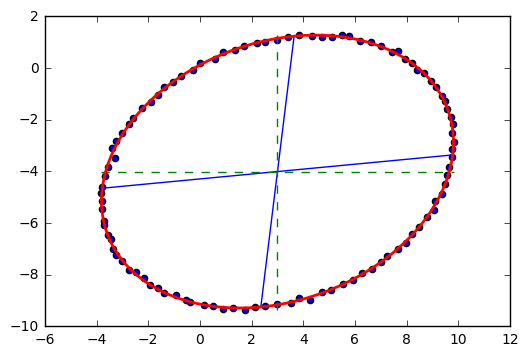

In [8]:
def calc_matfit(xc, yc, xx, yy, xy):
    xcen = x-xc
    ycen = y-yc
    xfit = xcen*xx+ycen*xy
    yfit = xcen*xy+ycen*yy
    return np.sqrt(xfit**2+yfit**2)
    

def lq_function_matfit(c):
    fit = calc_matfit(*c)
    return fit - 1

#get new parameter estimates
xsc_est = (x.max()+x.min())/2.
ysc_est = (y.max()+y.min())/2.
xsm_est = (x.max()-x.min())/2.
ysm_est = (y.max()-y.min())/2.

#fit data
params = xsc_est, ysc_est, 1/xsm_est, 1/ysm_est, -.1
params_out, ier = optimize.leastsq(lq_function_matfit, params)
xsc_fit, ysc_fit, xsm_fit, ysm_fit, xy_fit = params_out

#create scaling matrix
m = np.matrix([[xsm_fit, xy_fit], [xy_fit, ysm_fit]])
n = np.linalg.inv(m)
print 'Hard Iron Offsets'
print np.array([xsc_fit, ysc_fit])
print '\nScaling and Skew Correction Matrix'
print n

#plot fit
plt.scatter(x,y)
plt.plot(n[0,0]*np.array([-1,1])+xsc_fit,n[0,1]*np.array([-1,1])+ysc_fit,color='b')
plt.plot([x.min(),x.max()],[ysc_fit,ysc_fit],ls='--',color='g')
plt.plot(n[1,0]*np.array([-1,1])+xsc_fit,n[1,1]*np.array([-1,1])+ysc_fit,color='b')
plt.plot([xsc_fit,xsc_fit],[y.min(),y.max()],ls='--',color='g')
plt.plot(xunit*n[0,0]+yunit*n[0,1]+xsc_fit,xunit*n[1,0]+yunit*n[1,1]+ysc_fit,color='r',linewidth=2)
plt.show()


The fit looks good, so we can use the fit parameters to calibrate the data.

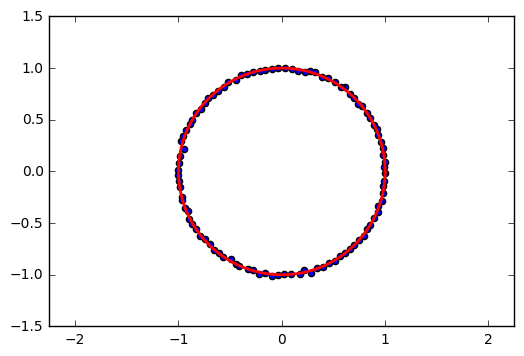

In [9]:
#calibrate data
xcent = (x-xsc_fit)
ycent = (y-ysc_fit)
xcal = xcent*xsm_fit+ycent*xy_fit
ycal = xcent*xy_fit+ycent*ysm_fit

#plot
plt.axis('equal')
plt.scatter(xcal,ycal)
plt.plot(xunit,yunit,color='r',linewidth=2) #unit circle
plt.show()


## Comparing Rotation vs. Symmetric Matrix

For 2D soft iron corrections, it is more common to see calibration being done by 1) using a rotation matrix to align the data ellipse axes with the x- and y-axis data, 2) scaling the data, then 3) de-rotating the data.  However, in the end, that is the same method as using a symmetric matrix and will result in the same calibration.  Referring to [Wolfram MathWorld](http://mathworld.wolfram.com/SymmetricMatrix.html), a symmetric matrix $A$ "is symmetric if it can be expressed in the form $A = QDQ^T$ where Q is an orthogonal matrix ($Q = -Q^T$) and $D$ is a diagonal matrix."  Notice that a rotation matrix is orthogonal, so we can let

$$
Q = \left( \begin{array}{cc}
\cos\theta & \sin\theta \\
-\sin\theta & \cos\theta \end{array} \right)\\
$$

and the scaling can be represented by a diagonal matrix, so let

$$
D = \left( \begin{array}{cc}
x_m & 0 \\
0 & y_m \end{array} \right)\\
$$

Using $A$ for our symmetric matrix, it should be true that

$$ 
A = QDQ^T = \left( \begin{array}{cc} 
\cos\theta & \sin\theta \\
-\sin\theta & \cos\theta \end{array} \right)
\left( \begin{array}{cc}
x_m & 0 \\
0 & y_m \end{array} \right)
\left( \begin{array}{cc} 
\cos\theta & -\sin\theta \\
\sin\theta & \cos\theta \end{array} \right)\\
$$

This means the symmetric matrix will be the result if the rotation, scaling, and de-rotation matrices are combined into one step.  However, using the symmetric matrix takes fewer steps, and only takes one fit rather than multiple fits that rely on each other.  Also, when doing 3-axis calibration, it is typical to use a 3x3 symmetric matrix for calibration instead of rotating the data.



# 3D Calibration: Hard and Soft Iron, Symmetric Matrix

Real magnetometer data can be found on github at

https://raw.githubusercontent.com/andrewkruger/Magnetometer_calibration/master/3d_soft.txt

First, upload and plot the data.

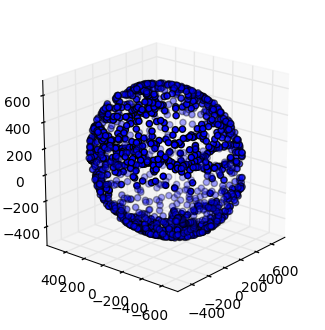

In [10]:
    #get data from github
x3,y3,z3 = np.genfromtxt("https://raw.githubusercontent.com/andrewkruger/Magnetometer_calibration/master/3d_soft.txt", unpack=True)

    #plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
ax.view_init(20,-140)
ax.autoscale_view(tight=True)
ax.scatter(x3,y3,z3)
plt.show()

It can be seen the data is not perfectly spherical.  This is due to soft iron effects.  First, we will demonstrate a calibration that would be used to correct for hard iron offsets and gain, which is often sufficient for calibrating a magnetometer.

The following will find the centroid and gain to the data, which is then used to calibrate the data.  As can be seen, this is the same as the gain and hard iron offset correction before, it's just that now a z-axis is included.

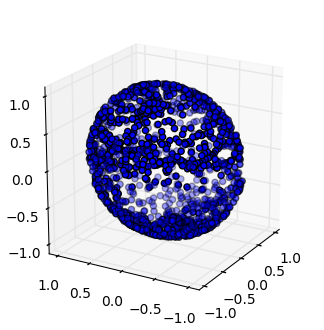

In [11]:
def calc_params3(xc, yc, zc, xm, ym, zm):
    return (((x3-xc)/xm)**2 + ((y3-yc)/ym)**2 + ((z3-zc)/zm)**2)    
    
def lq_function3(c):
    fit = calc_params3(*c)
    return fit - 1

    #get parameter estimates
x3_cen = (x3.max()+x3.min())/2.
y3_cen = (y3.max()+y3.min())/2.
z3_cen = (z3.max()+z3.min())/2.
x3_mag = (x3.max()-x3.min())/2.
y3_mag = (y3.max()-y3.min())/2.
z3_mag = (z3.max()-z3.min())/2.

    #fit data
params3_estimate = x3_cen, y3_cen, z3_cen, x3_mag, y3_mag, z3_mag
params3, ier = optimize.leastsq(lq_function3, params3_estimate)
xc_3, yc_3, zc_3, xm_3, ym_3, zm_3 = params3

    #calibrate data
x3_hcal = (x3-xc_3)/xm_3
y3_hcal = (y3-yc_3)/ym_3
z3_hcal = (z3-zc_3)/zm_3

    #plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
ax.view_init(20,-150)
ax.autoscale_view(tight=True)
ax.scatter(x3_hcal,y3_hcal,z3_hcal)
#ax.plot(np.zeros(npts_fit),xunit,yunit,color='r')
#ax.plot(xunit,np.zeros(npts_fit),yunit,color='r')
#ax.plot(xunit,yunit,np.zeros(npts_fit),color='r')
plt.show()



In the 3D scatter plot, the data sphere now goes from -1 to 1 in all three coordinate directions.  This calibration has been done basically the same as the 2D calibration with hard iron effects only, but with just one more coordinate added.  **This will be sufficient for most magnetometer calibrations.**  It doesn't even take much code to do this calibration!

However, you can probably see that this data is not perfectly spherical because there are soft iron effects that haven't been corrected.  To see the difference in shape from a sphere, look at the gif at https://gfycat.com/LastingDeterminedFawn showing this calibration (with partial data for better viewing) on a unit sphere.  As it spins and rotates, you can see the data is not properly calibrated, similar to the 2D data with soft iron effects that only had the hard iron effects corrected.

![Hard Iron Corrected](https://thumbs.gfycat.com/PolishedTemptingGopher-size_restricted.gif) 

To correct for the soft-iron effects, we can use the same technique as above, where we fit to a symmetric matrix.  Again, the only change is that a z-axis is now included.

In [12]:
def calc_params3_soft(x_ct, y_ct, z_ct, x_mt, y_mt, z_mt, xy_mt, xz_mt, yz_mt):
    xcen, ycen, zcen = x3-x_ct, y3-y_ct, z3-z_ct
    xscale = xcen*x_mt+ycen*xy_mt+zcen*xz_mt
    yscale = xcen*xy_mt+ycen*y_mt+zcen*yz_mt
    zscale = xcen*xz_mt+ycen*yz_mt+zcen*z_mt
    return np.sqrt(xscale**2+yscale**2+zscale**2)
    
def lq_function3_soft(c):
    fit = calc_params3_soft(*c)
    return fit - 1

params3_est_soft = x3_cen, y3_cen, z3_cen, 1/x3_mag, 1/y3_mag, 1/z3_mag, .0001, .0001, .0001
params3, ier = optimize.leastsq(lq_function3_soft, params3_est_soft)
xc_3, yc_3, zc_3, xm_3, ym_3, zm_3, xym, xzm, yzm = params3

m = np.array([[xm_3, xym, xzm],
              [xym, ym_3, yzm],
              [xzm, yzm, zm_3]])
A = np.linalg.inv(m)

print 'Hard Iron Offsets'
print np.array([xc_3, yc_3, zc_3])
print '\nSymmetric Scaling and Skew Matrix'
print A

Hard Iron Offsets
[ 108.989  -72.763   83.499]

Symmetric Scaling and Skew Matrix
[[ 591.022  -13.095  -14.971]
 [ -13.095  596.181   30.713]
 [ -14.971   30.713  552.062]]


We can compare our results to the fit made by MagCal (Information and software can be found by searching for "MagCal" here: http://plan.geomatics.ucalgary.ca/publications.php).  The outputs are in the same form as the outputs above.



<table class="image">
<caption align="bottom">Fit to the same data with MagCal.</caption>
<tr><td><img src="http://www.physi.cz/uploads/2/0/5/6/20564332/_9575284_orig.png" /></td></tr>
</table>


The fit parameters can be seen to be similar, all having less than 0.6% difference.


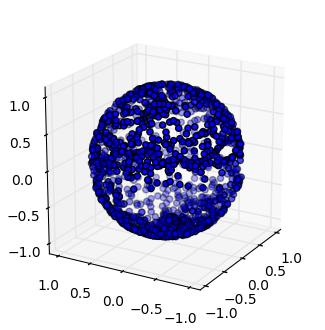

In [13]:
    #calibrate data
x3cen = (x3-xc_3)
y3cen = (y3-yc_3)
z3cen = (z3-zc_3)
x3_scal = x3cen*m[0][0]+y3cen*m[0][1]+z3cen*m[0][2]
y3_scal = x3cen*m[1][0]+y3cen*m[1][1]+z3cen*m[1][2]
z3_scal = x3cen*m[2][0]+y3cen*m[2][1]+z3cen*m[2][2]

    #plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
ax.view_init(20,-150)
ax.autoscale_view(tight=True)
ax.scatter(x3_scal,y3_scal,z3_scal)
plt.show()


Here we can see that the data is now properly calibrated with the off-axis skew removed.

![Soft Iron Corrected](https://thumbs.gfycat.com/ImpossibleDeepDobermanpinscher-size_restricted.gif)
